# Project Machine Learning LELEC2870

## Import 


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math as m


In [43]:
# import data set
X_1 = pd.read_csv('X1.csv')
X_2 = pd.read_csv('X2.csv')
y_1 = pd.read_csv('Y1.csv', header=None)
y_1.columns = ["target"]

## Data Exploratory Analysis 

### valid data set check 

In [4]:
# check wether dataset contains null values
print(X_1[["Age", "Height"]].isnull().sum())

# check wether dataset contains missing values
X_1.dropna()
print(X_1.count())

Age       0
Height    0
dtype: int64
Unnamed: 0                        250
Gender                            250
Age                               250
Height                            250
family_history_with_overweight    250
FAVC                              250
FCVC                              250
NCP                               250
CAEC                              250
SMOKE                             250
CH2O                              250
SCC                               250
FAF                               250
TUE                               250
CALC                              250
MTRANS                            250
dtype: int64


-> No null or missing observations for continuous variables

### continuous variables 

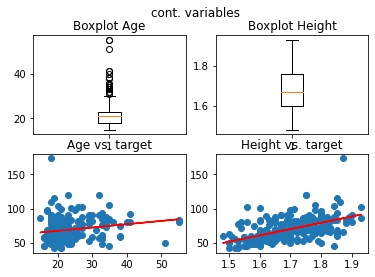

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle("cont. variables")

axes[0,0].boxplot(X_1["Age"])
axes[0,0].set_title('Boxplot Age')
axes[0,1].boxplot(X_1["Height"])
axes[0,1].set_title('Boxplot Height')

""" linearity between cont. var and target var """

# scat_plot_1
x = X_1['Age']
y = y_1['target']

stats = linregress(x, y)

m = stats.slope
b = stats.intercept

axes[1,0].scatter(x, y)
axes[1,0].plot(x, m * x + b, color='red')
axes[1,0].set_title('Age vs. target')

# scat_plot_2
x = X_1['Height']
y = y_1['target']

stats = linregress(x, y)

m = stats.slope
b = stats.intercept

axes[1,1].scatter(x, y)
axes[1,1].plot(x, m * x + b, color='red')
axes[1,1].set_title('Height vs. target')

plt.rcParams['figure.figsize'] = (10, 10)
plt.show()



$\bold{Age}$ is highly skewed, might be a problem for linreg later on whereas, $\bold{Height}$ seems to have no outliers

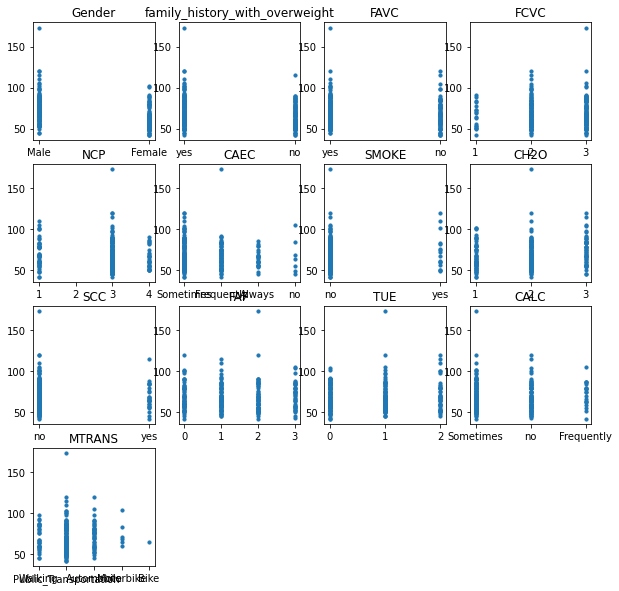

In [6]:
var_names = ['Gender', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 
'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
n_feats = len(var_names)
# 15 features

for i, var in enumerate(var_names):
    plt.subplot((n_feats//4+1), 4, i+1)
    plt.scatter(X_1[var], y_1, s=10)
    plt.title(var_names[i])

plt.rcParams['figure.figsize'] = (20, 20)
plt.tight_layout
plt.show()



E.G. MTRANS, aggréger des classes genre velo + à pied = sport/pas moteur

We need to pay attention to the fact that all the categories are not well balanced. i.e, there are way less non-smoker than smoker in the study 



In [44]:
# Data Cleaning :
# Je modifie les variable catégorielle sous forme de nombre en mots compréhensibles, c'est mieux pour la suite

# Création du dictionnaire
dummies_dict = {"FCVC": {1.0: "Never", 2.0: "Sometimes", 3.0: "Always"},
                  "NCP": {1.0: "Betw1_2", 2.0: "Three", 3.0: "Tree++"},
                  "CH2O": {1.0: "Less1L", 2.0: "Betw1_2", 3.0: "Two++"},
                  "FAF": {1.0: "no_acti", 2.0: "1_2Day", 3.0: "2_4Day", 4.0: "4_5Day"},
                  "TUE": {1.0: "0_2hour", 2.0: "3_5hour", 3.0: "Five++"}}

# Remplacement dans le dataframe
X_1 = X_1.replace(dummies_dict)
X_2 = X_2.replace(dummies_dict)

print(X_1.shape)
print(X_2.shape)

# Binarized categorical variables
X_1_cleaned = pd.get_dummies(X_1,
                                   columns=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                            "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"],
                                   prefix=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                           "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"], )#drop_first=True)

X_2_cleaned = pd.get_dummies(X_2,
                                   columns=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                            "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"],
                                   prefix=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                           "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"], )#drop_first=True )

X_2_cleaned = X_2_cleaned.drop(columns=['CALC_Always', 'Gender_Male', 'family_history_with_overweight_no', 'FAVC_no', 'SMOKE_no', 'SCC_no'])
X_1_cleaned = X_1_cleaned.drop(columns=['Gender_Male', 'family_history_with_overweight_no', 'FAVC_no', 'SMOKE_no', 'SCC_no'])

# explanatory with age and height scaled in order to give much more importance to dummies variables 
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

X_1_cleaned[['Age', 'Height']] = min_max_scaler.fit_transform(X_1_cleaned[['Age', 'Height']])
X_2_cleaned[['Age', 'Height']] = min_max_scaler.fit_transform(X_2_cleaned[['Age', 'Height']])
X_1_cleaned = X_1_cleaned.iloc[: , 1:]
X_2_cleaned = X_2_cleaned.iloc[: , 1:]

(250, 16)
(248, 16)


### features selection and splitting for LinReg model 

stepwise backward features selection

In [123]:
import statsmodels.api as sm

def backward_regression(X, y,
                           initial_list=[], 
                           list_removed=[],
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            #print(worst_feature,' rejected with p-value : ',round(worst_pval,4))
            included.remove(worst_feature)
            
        if not changed:
            break
    return included

In [124]:
bw = backward_regression(X_1_cleaned, y_1)
sub_X_1 = X_1_cleaned[bw]

## Scoring


In [11]:
# bmi calculator 
def get_bmi(w, h):
    return w/h**2


# RMSE calculator  
def compute_rmse(predict, target):
        # SOLUTION
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

def score_weight_class(bmi_pred, bmi_true, low, high):
    tol = 1
    vpred = (bmi_pred>=low-tol) & (bmi_pred<high+tol)
    vtrue = (bmi_true>=low) & (bmi_true<high)
    if vtrue.sum()==0:
        print("no true sample here")
        return 0
    
    rmse = np.sqrt(((bmi_true[vtrue]-bmi_pred[vtrue])**2).mean())
    rmse = rmse/(high-low+tol)
    acc = (vpred&vtrue).sum()/vtrue.sum()
    return rmse*(1-acc)


def score_regression(ytrue, ypred, height):
    bmi_pred = ypred/(height*height)
    bmi_true = ytrue/(height*height)

    score = []
    for bmi_low, bmi_high in zip([0,18.5,25,30],[18.5, 25, 30, 100]):
        score.append(score_weight_class(bmi_pred, bmi_true, low = bmi_low, high = bmi_high))
        return np.mean(score)

### Linear Regression 


constraint model 


In [125]:
X_train, X_test, y_train, y_test = train_test_split(sub_X_1, y_1, test_size=0.3)

In [126]:
model = LinearRegression().fit(X_train,y_train)
y_pred = model.predict(X_train)


# R^2
r_sq = model.score(X_train, y_train)
print('coefficient of determination:', round(r_sq, 4))

# RMSE 
print(round(compute_rmse(y_pred, y_train),4))
print("VARIABLES : ", bw, '\t')



coefficient of determination: 0.3599
13.6875
VARIABLES :  ['Age', 'Height', 'family_history_with_overweight_yes', 'NCP_Betw1_2', 'FAF_0.0'] 	


constrained model 

for the sake of classification we need to get catgorical variables to target. Hence, we compute the bmi of each obs in Y_1 to train the KNN model. 
We use it as well for MLP 

In [127]:
def mybmi(X,y) :
    # Retourne un dataframe avec un colonne nommée bmi reprenant le bmi de chaque individu 
    return pd.DataFrame(y/(X**2), columns =["bmi"])

bmi = mybmi(X_1["Height"],y_1["target"])
# On catégorise avec label 0,1,2,3
bmi["bmi"] = pd.cut(bmi["bmi"], bins=[0, 18.5, 25, 30, 100], labels=[0,1,2,3])

## KNN model

Splitting for KNN model 

In [128]:
X_train, X_test, bmi_train, bmi_test = train_test_split(sub_X_1, bmi, test_size=0.2, random_state=10)
bmi_train = bmi_train.to_numpy().astype(int).ravel()
bmi_test = bmi_test.to_numpy().astype(int).ravel()
len(bmi_train)
len(bmi_test)

50

Lien vers les explications : https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

## Constrained Model ['Age', 'Height', 'family_history_with_overweight_yes', 'NCP_Betw1_2', 'FAF_0.0'] 	

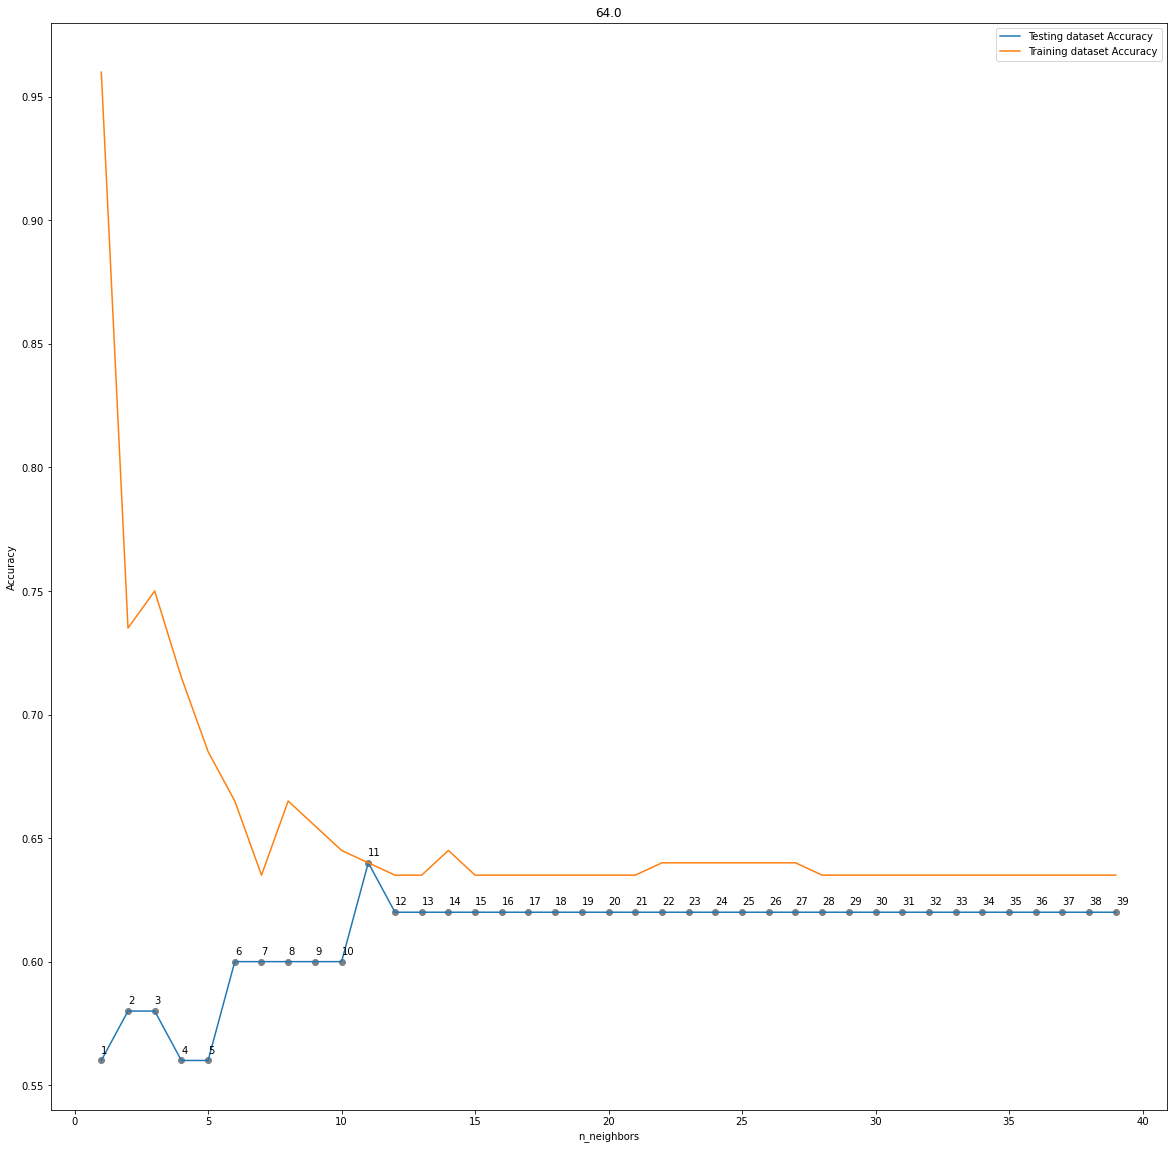

In [129]:
from sklearn.neighbors import KNeighborsClassifier

# init of the tunning 
neighbors = range(1,40)
train_acc = np.empty(len(neighbors))
test_acc = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    # on train sur sub, recall sub vient du backward features selection
    knn.fit(X_train, bmi_train)

    # array that contains acc_score of both samples
    train_acc[i] = knn.score(X_train, bmi_train)
    test_acc[i] = knn.score(X_test, bmi_test)

plt.plot(neighbors, test_acc, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_acc, label = 'Training dataset Accuracy')
for k, acc in enumerate(test_acc):
    plt.text(k+1, acc+0.003, k+1)
    plt.scatter(k+1,acc, c = 'grey')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title(max(test_acc)*100)
plt.show()

## Full Model 